In [133]:
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np

In [134]:
46.296423 * np.sin(np.radians(87))

46.23297536129095

In [135]:
plt.rcParams['figure.dpi'] = 200

In [136]:
lc_collection = lk.search_lightcurvefile('alpha Draconis', mission='TESS').download_all()

In [137]:
lc = lc_collection[0].SAP_FLUX.normalize()
lc = lc.append(lc_collection[1].SAP_FLUX.normalize())
lc = lc.remove_nans()

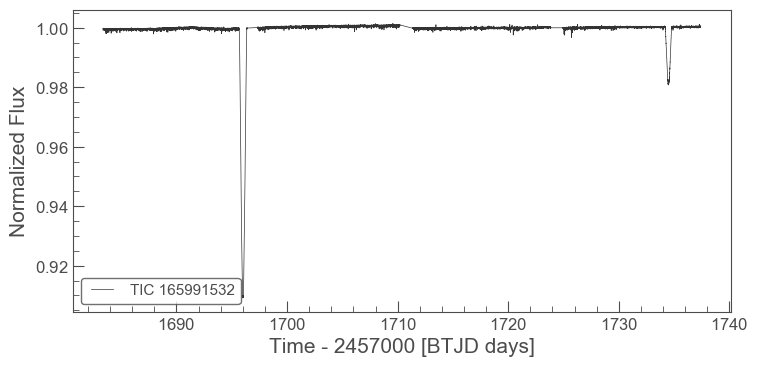

In [138]:
lc.plot()

In [19]:
folded = lc.fold(51.4167)
ax = folded.plot()
folded.bin().scatter(ax=ax, c='green')

In [8]:
t, y, yerr = np.loadtxt('data/lc.txt', usecols=(0,1,2)).T
t_rv, rv, rverr = np.loadtxt('data/bischoff_rv.txt',usecols=(0,1,2)).T
t_rv += 2450000
t_rv -= 2457000

In [61]:
import phoebe

def init_bundle():
    """
    This is a convenience function to make a simple bundle for fitting, with all the constraints flipped around
    """
    bundle = phoebe.default_binary()
    
    # Speedups
    phoebe.interactive_constraints_off()
    bundle.get_parameter(context='compute', qualifier='irrad_method').set_value("none")
    bundle.get_parameter(context='compute', component='primary', qualifier='ntriangles').set_value(300)
    bundle.get_parameter(context='compute', component='secondary', qualifier='ntriangles').set_value(300)
    
    # Add some fitting constraints
    bundle.add_constraint('requivratio')
    bundle.add_constraint('requivsum')
    bundle.add_constraint('teffratio')

    # And flip them
    bundle.flip_constraint('requivratio', solve_for='requiv@primary')
    bundle.flip_constraint('requivsum', solve_for='requiv@secondary')
    bundle.flip_constraint('teffratio', solve_for='teff@secondary@component')
    bundle.flip_constraint('esinw', solve_for='ecc')
    bundle.flip_constraint('ecosw', solve_for='per0')
    
    return bundle

def model(params, twigs, bundle, time):
    """
    Our model, takes in an array of parameter values, their corresponding twigs (sue me)
    in Phoebe, and a bundle object, and returns the flux at those values.
    """
    # Iterate over pairs of parameter and twig values, assigning them to the bundle
    for param, twig in zip(params, twigs):
        bundle[twig] = param
    
    bundle.run_compute()
    
    # Since i'm fitting a transit initially, I don't want no interpolation
    flux = bundle['fluxes@latest@model'].get_value()#.interp_value(times=time)
    return flux# / np.max(flux)

def lnlike(params, twigs, bundle, flux, time, flux_err):
    try:
        print(params)
        model_flux = model(params, twigs, bundle, time)
        return -0.5 * np.sum((flux - model_flux)**2 / flux_err**2)
    except:
        # Here we catch overflows in the model. This is a cheap prior that should be implemented properly
        return -np.inf
    
def sort_flux(time, period, flux):
    fold_time = time % period / period
    sort = np.argsort(fold_time)
    return fold_time[sort], flux[sort]

In [9]:
t0_guess = t[np.argmin(y)]

spacing = 0.4

y_transit = y[(t > t0_guess-spacing) & (t < t0_guess+spacing)][::20]
t_transit = t[(t > t0_guess-spacing) & (t < t0_guess+spacing)][::20]
yerr_transit = yerr[(t > t0_guess-spacing) & (t < t0_guess+spacing)][::10]

plt.plot(t_transit, y_transit, '.k')
plt.xlabel('Time')
plt.ylabel('Flux')

t1_guess = t[t>1700][np.argmin(y[t>1700])]
y_transit2 = y[(t > t1_guess-spacing) & (t < t1_guess+spacing)][::20]
t_transit2 = t[(t > t1_guess-spacing) & (t < t1_guess+spacing)][::20]
yerr_transit = yerr[(t > t1_guess-spacing) & (t < t1_guess+spacing)][::10]

plt.plot(t_transit, y_transit, '.k')
plt.plot(t_transit2, y_transit2, '.k')
plt.xlabel('Time')
plt.ylabel('Flux')

Text(0, 0.5, 'Flux')

In [121]:
# Our humble phoebe bundle
b = phoebe.default_binary()

# Let's add our primary transit, and set things to be dataset scaled
b.add_dataset('lc', times=t, fluxes=y, dataset='full_lc')
# b.add_dataset('rv', times=t_rv, rv=rv, dataset='rv01')
# b.add_dataset('mesh', times=t, columns=['intensities@full_lc'], dataset='mesh01')

b['pblum_mode'] = 'dataset-scaled'

b.flip_constraint('esinw', solve_for='ecc')
b.flip_constraint('ecosw', solve_for='per0')

b.flip_constraint('compute_phases@full_lc', 'compute_times@full_lc@lc@dataset')

phases = np.linspace(0,1,101)
b.set_value('compute_phases@full_lc@lc', phases)

Text(0, 0.5, 'Flux (norm)')

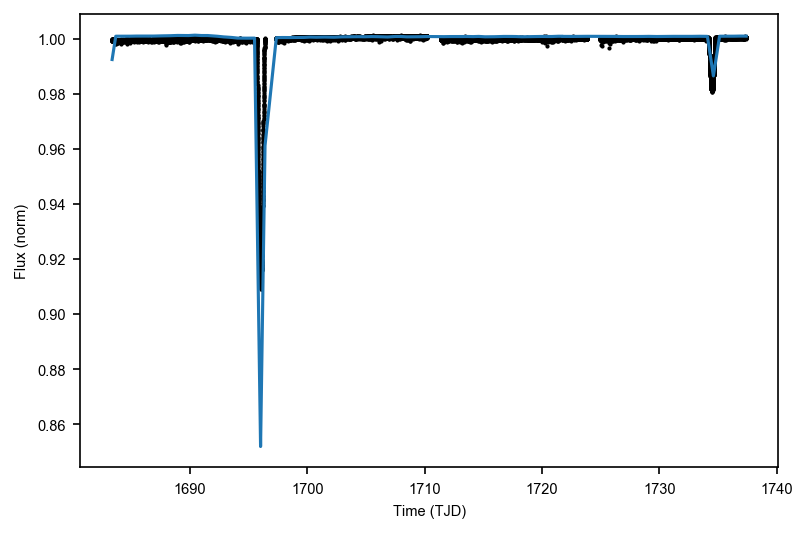

In [131]:
b['period@orbit'] = 51.472162
b['sma@component@orbit'] = 46.296423 * np.sin(np.radians(87))
b['t0_supconj'] = t0_guess
b['ecosw'] = 0.39553496225126916
b['esinw'] = 0.15820269794440003

b['incl@orbit'] = 87
b['requiv@primary'] = 3.2
b['requiv@primary'] = 2.2
b['teff@primary'] = 10100
b['teff@secondary'] = 6500

b.run_compute() 
flux = b['fluxes@latest@model'].interp_value(times=t)

plt.plot(t, y, '.k', markersize=2, zorder=1)
plt.plot(t, flux, zorder=5)
plt.xlabel('Time (TJD)')
plt.ylabel('Flux (norm)')

In [10]:
full_transit_time, full_transit_flux = np.append(t_transit, t_transit2), np.append(y_transit, y_transit2)

In [12]:
np.savetxt('data/all_transits.txt', list(zip(full_transit_time, full_transit_flux)))

In [114]:
# Our humble phoebe bundle
b = init_bundle()

# Let's add our primary transit, and set things to be dataset scaled
b.add_dataset('lc', times=t, fluxes=y, dataset='full_lc')
# b.add_dataset('rv', times=t_rv, rv=rv, dataset='rv01')
# b.add_dataset('mesh', times=t, columns=['intensities@full_lc'], dataset='mesh01')

b['pblum_mode'] = 'dataset-scaled'

In [115]:
b.flip_constraint('compute_phases@full_lc', 'compute_times@full_lc@lc@dataset')
# b.flip_constraint('compute_phases@mesh01', 'compute_times@mesh01@dataset')

phases = np.linspace(0,1,101)
b.set_value('compute_phases@full_lc@lc', phases)
# b.set_value('compute_phases@mesh01', phases)

Text(0, 0.5, 'Flux (norm)')

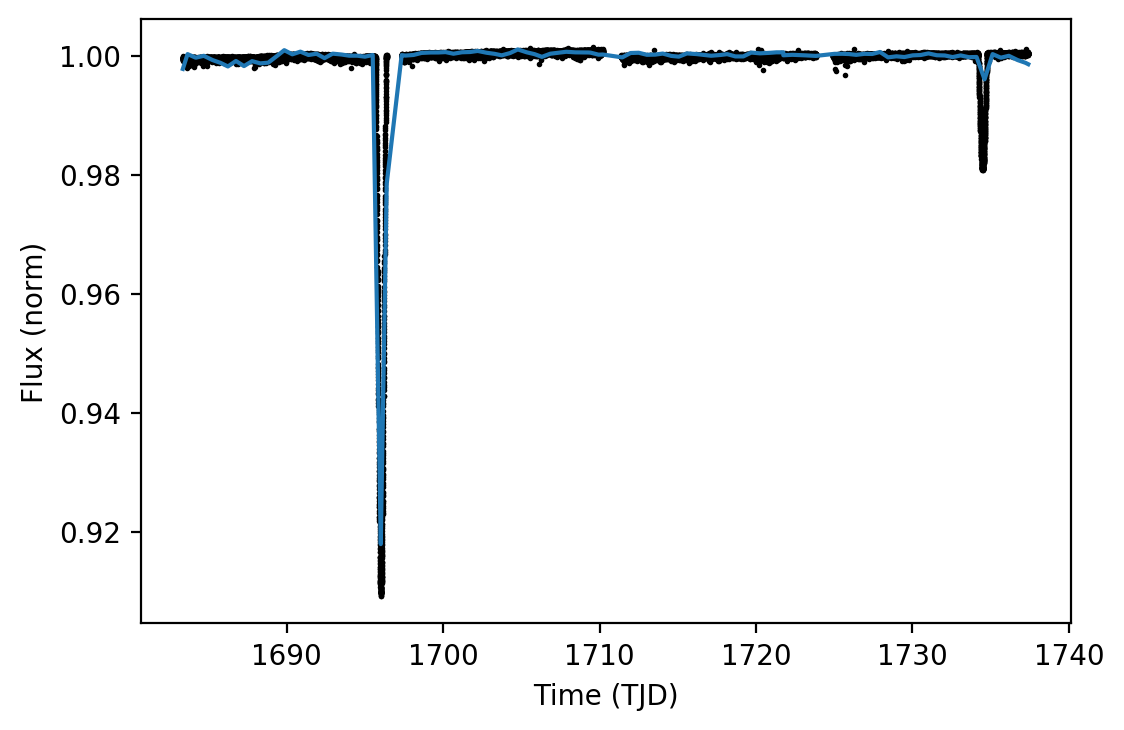

In [95]:
b['period@orbit'] = 51.472162
b['sma@component@orbit'] = 46.296423 * np.sin(np.radians(87))
b['t0_supconj'] = t0_guess
b['ecosw'] = 0.39553496225126916
b['esinw'] = 0.15820269794440003

b['incl@orbit'] = 87
b['requivratio'] = 0.3
b['requivsum'] = 3
b['teffratio'] = 0.7
b['q'] = 0.92

b.run_compute() 
# eph = np.linspace(t[0], t[-1] + 60, 500)
flux = b['fluxes@latest@model'].interp_value(times=t)

plt.plot(t, y, '.k', markersize=2, zorder=1)
plt.plot(t, flux, zorder=5)
plt.xlabel('Time (TJD)')
plt.ylabel('Flux (norm)')
# plt.savefig('eph.png', dpi=200)

# rvrv = b['rvs@primary@rv01@phoebe01@latest@rv@model'].get_value()#.interp_value(times=t)
# plt.plot(t_rv, rvrv)
# plt.plot(t_rv, rv, '--k')

In [227]:
for i, phase in enumerate(phases):    
    b['mesh@model'].plot(fc='intensities@full_lc', ec='None', phase=phase, show=False)
    fig = plt.figure(figsize=(10,7))
    b.savefig('anim/{}.png'.format(i), fig=fig, tight_layouot=True, draw_sidebars=False)
    plt.clf()
    plt.close(fig)

In [100]:
%run setup.py

In [105]:
mnras_size(540.)

[7.5, 4.635254915624212]

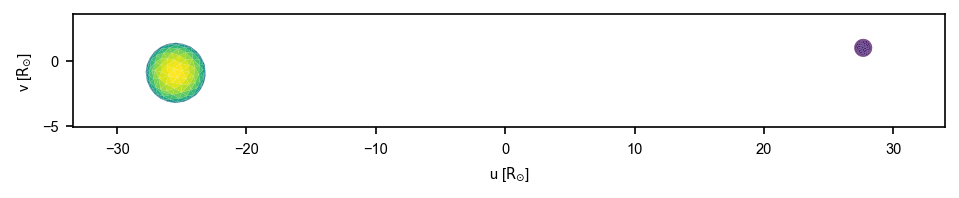

In [109]:
fig = plt.figure(figsize=[7.5, 1])
fig, afig = b['mesh@model'].plot(fc='intensities@full_lc', ec='None', phases=0.5, show=True, )

# 
# b.savefig('animation_binary_complete.gif', fig=fig, tight_layouot=True, draw_sidebars=False, animate=True, save_kwargs={'writer': 'imagemagick'})

In [113]:
afig.savefig('figs/cartoon.png', dpi=300, bbox_inches='tight', pad_inches=0)

Text(0, 0.5, 'Flux (norm)')

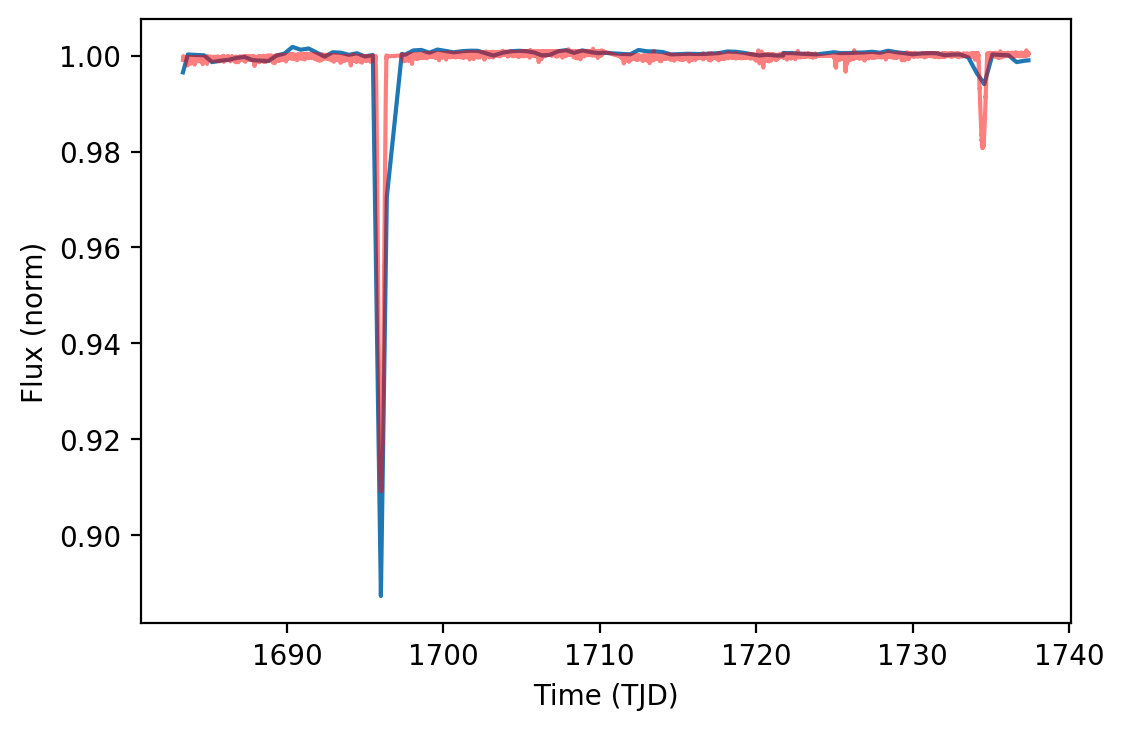

In [95]:
initial = np.array([2,  5, 1.5])
twigs = ['requivratio', 'requivsum','teffratio']

b['period@orbit'] = 51.439
b['sma@component@orbit'] = 46.296423
b['t0_supconj'] = t0_guess

# b['teffratio'] = 0.63
# b['requivratio'] = 0.3
# b['requivsum'] = 3


b['teffratio'] = 0.63
b['requivratio'] = 0.3
b['requivsum'] = 2

b.run_compute() 
eph = np.linspace(t[0], t[-1] + 60, 500)
flux = b['fluxes@latest@model'].interp_value(times=t)
# plt.plot(*sort_flux(t, b['period@orbit'].value, flux))
# plt.plot(*sort_flux(t, b['period@orbit'].value, y))

plt.plot(t, flux)
plt.plot(t, y, c='red', alpha=0.5)
plt.xlabel('Time (TJD)')
plt.ylabel('Flux (norm)')
# plt.savefig('eph.png', dpi=200)

In [ ]:
b['period@orbit'] = 51.4167
b['sma@component@orbit'] = 46.296423
b['t0_supconj'] = t0_guess
b['ecosw'] = 0.39553496225126916
b['esinw'] = 0.15820269794440003

In [133]:
import batman
import numpy as np
import matplotlib.pyplot as plt

params = batman.TransitParams()       #object to store transit parameters
params.t0 = t0_guess                      #time of inferior conjunction
params.per = 51.4167                      #orbital period
params.rp = 2                     #planet radius (in units of stellar radii)
params.a = 46.2                        #semi-major axis (in units of stellar radii)
params.inc = 87.                      #orbital inclination (in degrees)
params.ecc = 0.                       #eccentricity
params.w = 22.8                       #longitude of periastron (in degrees)
params.limb_dark = "nonlinear"        #limb darkening model
params.u = [0.5, 0.1, 0.1, -0.1]      #limb darkening coefficients [u1, u2, u3, u4]
params.fp = 0.1
params.t_secondary = 0.5

# t = np.linspace(-0.025, 0.025, 1000)  #times at which to calculate light curve
m = batman.TransitModel(params, t)    #initializes model
m2 = batman.TransitModel(params, t, transittype="secondary")
flux = m.light_curve(params)+m2.light_curve(params)                  #calculates light curve
flux /= np.max(flux)

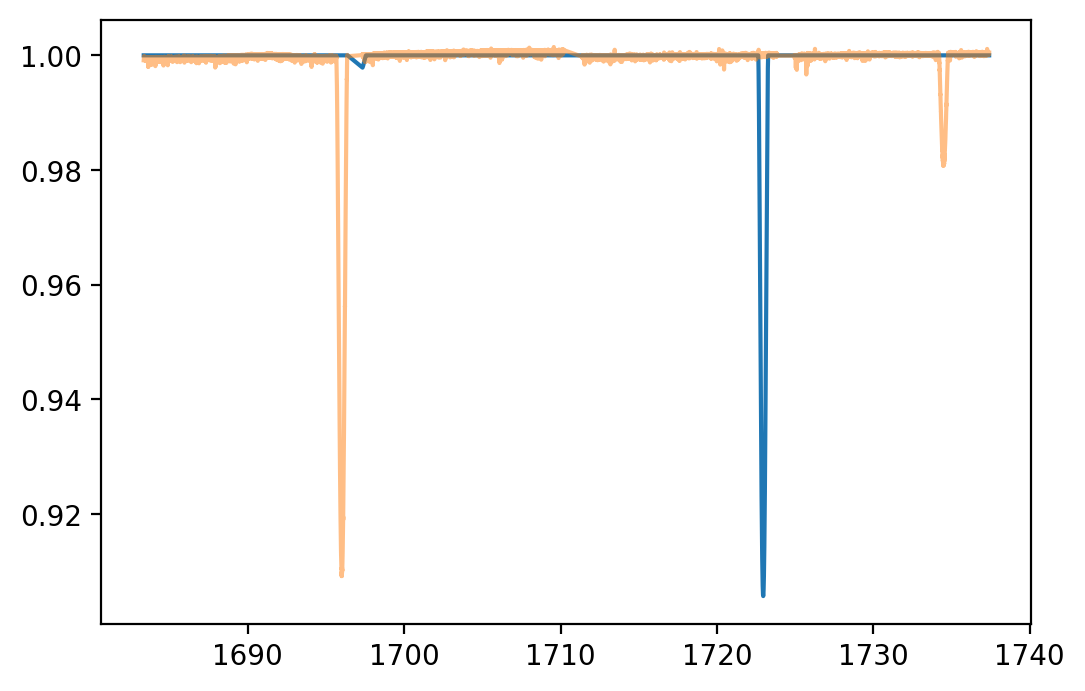

In [134]:
plt.plot(t, flux)
plt.plot(t,y, alpha=0.5)

In [59]:
from scipy.optimize import minimize

# Since we're using an optimizer, we want to minimise the negative log-likelihood. Here's a lambda function
# which aliases `lnlike`.
nll = lambda *args: -lnlike(*args)

In [60]:
# Let's fit!
soln = minimize(nll, params, args=(twigs, b, y_transit, t_transit, yerr_transit), 
               method='Nelder-Mead', tol=100
               )

In [61]:
soln

 final_simplex: (array([[  54.06560819, 1680.75808331],
       [  54.06564864, 1680.72280293],
       [  54.06567959, 1680.73595978]]), array([1.69956562e+08, 1.69956572e+08, 1.69956628e+08]))
           fun: 169956562.1143384
       message: 'Optimization terminated successfully.'
          nfev: 65
           nit: 27
        status: 0
       success: True
             x: array([  54.06560819, 1680.75808331])

In [62]:
# Here I assign the optimised values back to the bundle
for param, twig in zip(soln['x'], twigs):
    b[twig] = param

In [63]:
b['period@orbit'] = 51.4167

In [ ]:
initial = np.array([87, 0.6,2.])
twigs = ['incl@orbit', 'requivratio', 'requivsum']
soln = minimize(nll, initial, args=(twigs, b, y_transit, t_transit, yerr_transit), 
                method='Nelder-Mead', tol=100
               )